In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
import random

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.lenses import lens_util

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-068
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
# debugging = True  # TODO TEMP

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

detectable_lenses = lens_util.get_detectable_lenses(pipeline_dir, with_subhalos=False, verbose=True)

100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


In [3]:
high_snr_lenses = [l for l in detectable_lenses if l.snr > 200]
print(f'Number of lenses with SNR > 200: {len(high_snr_lenses)}')

Number of lenses with SNR > 200: 78


In [4]:
snr_masks = [l.masked_snr_array for l in high_snr_lenses]

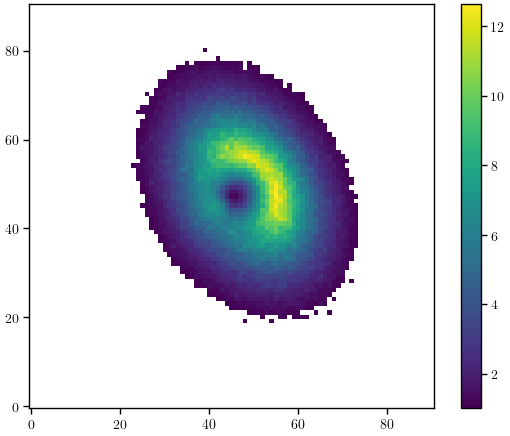

In [5]:
plt.imshow(snr_masks[0], cmap='viridis')
plt.colorbar()
plt.show()

In [9]:
pprint(snr_masks[0])

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)


Mean of median SNRs: 3.70
Standard deviation of median SNRs: 0.43


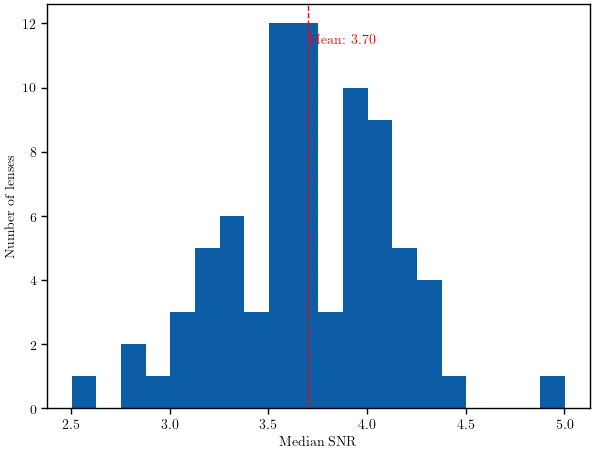

In [14]:
median_snrs = [np.median(mask.compressed()) for mask in snr_masks]

mean_median_snr = np.mean(median_snrs)
std_median_snr = np.std(median_snrs)

print(f'Mean of median SNRs: {mean_median_snr:.2f}')
print(f'Standard deviation of median SNRs: {std_median_snr:.2f}')

plt.hist(median_snrs, bins=20)
plt.axvline(np.mean(median_snrs), color='r', linestyle='dashed', linewidth=1)
plt.text(np.mean(median_snrs), plt.ylim()[1] * 0.9, f'Mean: {np.mean(median_snrs):.2f}', color='r')
plt.xlabel('Median SNR')
plt.ylabel('Number of lenses')
plt.show()

Mean of median SNRs: 2.26
Standard deviation of median SNRs: 0.57


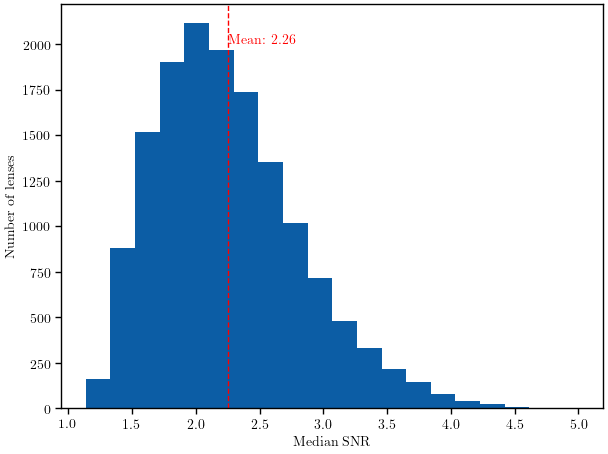

In [15]:
all_snr_masks = [l.masked_snr_array for l in detectable_lenses]
all_median_snrs = [np.median(mask.compressed()) for mask in all_snr_masks]

mean_all_median_snr = np.mean(all_median_snrs)
std_all_median_snr = np.std(all_median_snrs)

print(f'Mean of median SNRs: {mean_all_median_snr:.2f}')
print(f'Standard deviation of median SNRs: {std_all_median_snr:.2f}')

plt.hist(all_median_snrs, bins=20)
plt.axvline(np.mean(all_median_snrs), color='r', linestyle='dashed', linewidth=1)
plt.text(np.mean(all_median_snrs), plt.ylim()[1] * 0.9, f'Mean: {np.mean(all_median_snrs):.2f}', color='r')
plt.xlabel('Median SNR')
plt.ylabel('Number of lenses')
plt.show()

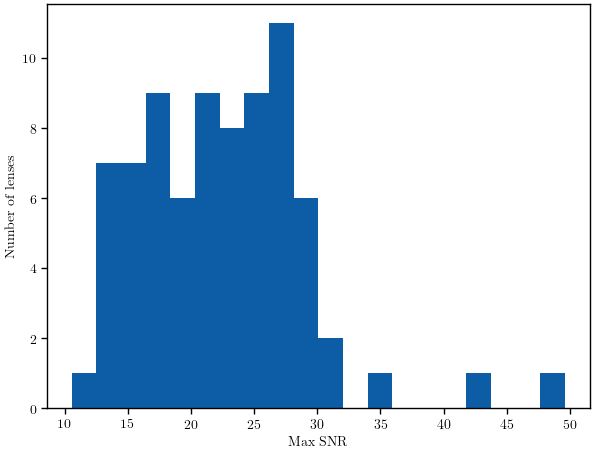

In [8]:
max_snrs = [np.max(mask) for mask in snr_masks]

plt.hist(max_snrs, bins=20)
plt.xlabel('Max SNR')
plt.ylabel('Number of lenses')
plt.show()